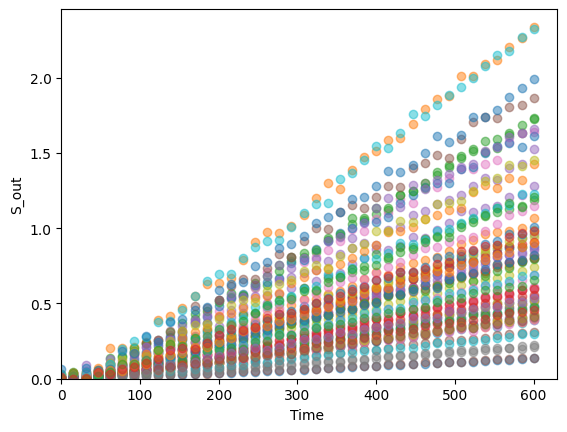

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.data import SyntheticDataGenerator, CustomDataset, get_data_loaders
from torch.optim import Adam
from torch.utils.data import random_split
from src.models.crnn import CRNN
from tqdm import trange

gen = SyntheticDataGenerator.from_hardcoded_1latent(
    reaction_rates = (2e3*1e-9, 2e7*1e-9),
    initial_concentration_range=(10.0, 50.0),
    t_end=60 * 10,
    n_timepoints=40,
    seed=0,
)

batch = gen.generate_dataset(64)
import matplotlib.pyplot as plt
for y in batch["y"]:
    plt.scatter(batch["t"], y.numpy(), alpha=0.5)

plt.xlabel("Time ")
plt.ylabel("S_out")
plt.ylim(0,)
plt.xlim(0,)
plt.show()


In [4]:
def train_step(model, batch, out_idx, optimizer, device="cpu"):
    model.train()

    # ---- unpack batch ----
    t = batch["t"].to(device).float()
    if t.ndim == 2:        # dataloader may stack time
        t = t[0]           # (T,)

    c0 = batch["c0"].to(device).float()      # (B,S)
    y_true = batch["y"].to(device).float()   # (B,T)

    # ---- forward ----
    optimizer.zero_grad(set_to_none=True)

    C_pred = model(t, c0)                     # (B,T,S)
    y_pred = C_pred[:, :, out_idx]            # (B,T)

    loss = torch.mean((y_pred - y_true) ** 2)

    # ---- backward ----
    loss.backward()

    # critical for Neural ODE stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    return loss.item()

def fit(
    model,
    train_loader,
    out_idx,
    epochs=100,
    lr=1e-4,
    device="cpu",
    print_every=1,
):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    history = []

    for epoch in trange(1, epochs + 1, desc="Training"):
        running = 0.0
        n = 0

        for batch in train_loader:
            loss = train_step(model, batch, out_idx, optimizer, device)
            running += loss
            n += 1

        epoch_loss = running / max(n, 1)
        history.append(epoch_loss)

        if epoch % print_every == 0:
            with torch.no_grad():
                nu = model.nu()
                print(
                    f"Epoch {epoch:03d} | "
                    f"loss={epoch_loss:.4e} | "
                    f"log_k={model.log_k.detach().cpu().numpy()} | "
                    f"nu={nu}"
                )

    return history



In [5]:
ds = CustomDataset(batch)
len(ds)

64

In [6]:
n = len(ds)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])


train_loader, val_loader, test_loader = get_data_loaders(
    train_ds, val_ds, test_ds,
    batch_size=8,
    num_workers=0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset ))
# model
model = CRNN(
    N=gen.composition_matrix,
    num_reactions=1,
)

out_idx = gen.partition.output_indices[0]

# train
history = fit(
    model,
    train_loader,
    out_idx,
    epochs=100,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


51 6 7


Training:   1%|          | 1/100 [00:00<00:25,  3.91it/s]

Epoch 001 | loss=3.4062e-01 | log_k=[-0.00571461] | nu=tensor([[ 0.0127],
        [ 0.0127],
        [-0.0137],
        [ 0.0010],
        [ 0.0010]])


Training:   2%|▏         | 2/100 [00:00<00:23,  4.12it/s]

Epoch 002 | loss=2.3633e-01 | log_k=[-0.00878322] | nu=tensor([[ 0.0131],
        [ 0.0131],
        [-0.0137],
        [ 0.0006],
        [ 0.0006]])


Training:   3%|▎         | 3/100 [00:00<00:23,  4.10it/s]

Epoch 003 | loss=1.3692e-01 | log_k=[-0.01026632] | nu=tensor([[ 0.0125],
        [ 0.0125],
        [-0.0148],
        [ 0.0023],
        [ 0.0023]])


Training:   4%|▍         | 4/100 [00:00<00:23,  4.14it/s]

Epoch 004 | loss=8.7364e-02 | log_k=[-0.01216623] | nu=tensor([[ 0.0127],
        [ 0.0127],
        [-0.0148],
        [ 0.0021],
        [ 0.0021]])


Training:   5%|▌         | 5/100 [00:01<00:22,  4.14it/s]

Epoch 005 | loss=6.9840e-02 | log_k=[-0.01334577] | nu=tensor([[ 0.0129],
        [ 0.0129],
        [-0.0148],
        [ 0.0019],
        [ 0.0019]])


Training:   6%|▌         | 6/100 [00:01<00:22,  4.12it/s]

Epoch 006 | loss=7.6021e-02 | log_k=[-0.01336656] | nu=tensor([[ 0.0126],
        [ 0.0126],
        [-0.0152],
        [ 0.0026],
        [ 0.0026]])


Training:   7%|▋         | 7/100 [00:01<00:22,  4.12it/s]

Epoch 007 | loss=8.6510e-02 | log_k=[-0.01492003] | nu=tensor([[ 0.0130],
        [ 0.0130],
        [-0.0147],
        [ 0.0017],
        [ 0.0017]])


Training:   8%|▊         | 8/100 [00:01<00:22,  4.13it/s]

Epoch 008 | loss=1.0744e-01 | log_k=[-0.01585459] | nu=tensor([[ 0.0132],
        [ 0.0132],
        [-0.0146],
        [ 0.0014],
        [ 0.0014]])


Training:   9%|▉         | 9/100 [00:02<00:22,  4.13it/s]

Epoch 009 | loss=8.3041e-02 | log_k=[-0.0150645] | nu=tensor([[ 0.0125],
        [ 0.0125],
        [-0.0155],
        [ 0.0030],
        [ 0.0030]])


Training:  10%|█         | 10/100 [00:02<00:21,  4.12it/s]

Epoch 010 | loss=1.1293e-01 | log_k=[-0.01688848] | nu=tensor([[ 0.0128],
        [ 0.0128],
        [-0.0153],
        [ 0.0025],
        [ 0.0025]])


Training:  11%|█         | 11/100 [00:02<00:21,  4.09it/s]

Epoch 011 | loss=8.0615e-02 | log_k=[-0.01900475] | nu=tensor([[ 0.0133],
        [ 0.0133],
        [-0.0149],
        [ 0.0016],
        [ 0.0016]])


Training:  12%|█▏        | 12/100 [00:02<00:21,  4.11it/s]

Epoch 012 | loss=8.5410e-02 | log_k=[-0.01909792] | nu=tensor([[ 0.0130],
        [ 0.0130],
        [-0.0154],
        [ 0.0024],
        [ 0.0024]])


Training:  13%|█▎        | 13/100 [00:03<00:21,  4.11it/s]

Epoch 013 | loss=1.0689e-01 | log_k=[-0.01952742] | nu=tensor([[ 0.0128],
        [ 0.0128],
        [-0.0157],
        [ 0.0029],
        [ 0.0029]])


Training:  14%|█▍        | 14/100 [00:03<00:20,  4.14it/s]

Epoch 014 | loss=1.0040e-01 | log_k=[-0.02239115] | nu=tensor([[ 0.0136],
        [ 0.0136],
        [-0.0149],
        [ 0.0013],
        [ 0.0013]])


Training:  15%|█▌        | 15/100 [00:03<00:20,  4.14it/s]

Epoch 015 | loss=9.7657e-02 | log_k=[-0.02298721] | nu=tensor([[ 0.0133],
        [ 0.0133],
        [-0.0154],
        [ 0.0021],
        [ 0.0021]])


Training:  16%|█▌        | 16/100 [00:03<00:20,  4.13it/s]

Epoch 016 | loss=8.4284e-02 | log_k=[-0.02400523] | nu=tensor([[ 0.0134],
        [ 0.0134],
        [-0.0154],
        [ 0.0020],
        [ 0.0020]])


Training:  17%|█▋        | 17/100 [00:04<00:20,  4.13it/s]

Epoch 017 | loss=8.3400e-02 | log_k=[-0.02427724] | nu=tensor([[ 0.0133],
        [ 0.0133],
        [-0.0156],
        [ 0.0023],
        [ 0.0023]])


Training:  18%|█▊        | 18/100 [00:04<00:19,  4.16it/s]

Epoch 018 | loss=8.2020e-02 | log_k=[-0.02483041] | nu=tensor([[ 0.0134],
        [ 0.0134],
        [-0.0155],
        [ 0.0022],
        [ 0.0022]])


Training:  19%|█▉        | 19/100 [00:04<00:23,  3.44it/s]

Epoch 019 | loss=9.9673e-02 | log_k=[-0.02608256] | nu=tensor([[ 0.0137],
        [ 0.0137],
        [-0.0151],
        [ 0.0014],
        [ 0.0014]])


Training:  20%|██        | 20/100 [00:05<00:21,  3.65it/s]

Epoch 020 | loss=9.1010e-02 | log_k=[-0.02605203] | nu=tensor([[ 0.0135],
        [ 0.0135],
        [-0.0155],
        [ 0.0020],
        [ 0.0020]])


Training:  21%|██        | 21/100 [00:05<00:20,  3.80it/s]

Epoch 021 | loss=8.1032e-02 | log_k=[-0.02670089] | nu=tensor([[ 0.0136],
        [ 0.0136],
        [-0.0154],
        [ 0.0018],
        [ 0.0018]])


Training:  22%|██▏       | 22/100 [00:05<00:20,  3.85it/s]

Epoch 022 | loss=7.5090e-02 | log_k=[-0.02643606] | nu=tensor([[ 0.0134],
        [ 0.0134],
        [-0.0157],
        [ 0.0024],
        [ 0.0024]])


Training:  23%|██▎       | 23/100 [00:05<00:19,  3.91it/s]

Epoch 023 | loss=8.1704e-02 | log_k=[-0.02738071] | nu=tensor([[ 0.0136],
        [ 0.0136],
        [-0.0155],
        [ 0.0020],
        [ 0.0020]])


Training:  24%|██▍       | 24/100 [00:05<00:19,  3.98it/s]

Epoch 024 | loss=8.0201e-02 | log_k=[-0.02745946] | nu=tensor([[ 0.0134],
        [ 0.0134],
        [-0.0157],
        [ 0.0023],
        [ 0.0023]])


Training:  25%|██▌       | 25/100 [00:06<00:18,  4.02it/s]

Epoch 025 | loss=8.3380e-02 | log_k=[-0.02786831] | nu=tensor([[ 0.0135],
        [ 0.0135],
        [-0.0157],
        [ 0.0022],
        [ 0.0022]])


Training:  26%|██▌       | 26/100 [00:06<00:18,  4.07it/s]

Epoch 026 | loss=8.8485e-02 | log_k=[-0.02875412] | nu=tensor([[ 0.0137],
        [ 0.0137],
        [-0.0155],
        [ 0.0018],
        [ 0.0018]])


Training:  27%|██▋       | 27/100 [00:06<00:18,  4.02it/s]

Epoch 027 | loss=8.1830e-02 | log_k=[-0.02827819] | nu=tensor([[ 0.0133],
        [ 0.0133],
        [-0.0160],
        [ 0.0027],
        [ 0.0027]])


Training:  28%|██▊       | 28/100 [00:06<00:17,  4.07it/s]

Epoch 028 | loss=8.2978e-02 | log_k=[-0.03049122] | nu=tensor([[ 0.0140],
        [ 0.0140],
        [-0.0153],
        [ 0.0013],
        [ 0.0013]])


Training:  29%|██▉       | 29/100 [00:07<00:17,  4.14it/s]

Epoch 029 | loss=1.1150e-01 | log_k=[-0.03101999] | nu=tensor([[ 0.0138],
        [ 0.0138],
        [-0.0157],
        [ 0.0019],
        [ 0.0019]])


Training:  30%|███       | 30/100 [00:07<00:17,  4.11it/s]

Epoch 030 | loss=8.5792e-02 | log_k=[-0.03171451] | nu=tensor([[ 0.0136],
        [ 0.0136],
        [-0.0160],
        [ 0.0024],
        [ 0.0024]])


Training:  31%|███       | 31/100 [00:07<00:16,  4.13it/s]

Epoch 031 | loss=8.6090e-02 | log_k=[-0.03260634] | nu=tensor([[ 0.0137],
        [ 0.0137],
        [-0.0160],
        [ 0.0023],
        [ 0.0023]])


Training:  32%|███▏      | 32/100 [00:07<00:16,  4.05it/s]

Epoch 032 | loss=7.5595e-02 | log_k=[-0.0337953] | nu=tensor([[ 0.0140],
        [ 0.0140],
        [-0.0157],
        [ 0.0018],
        [ 0.0018]])


Training:  33%|███▎      | 33/100 [00:08<00:16,  3.94it/s]

Epoch 033 | loss=8.5416e-02 | log_k=[-0.03360097] | nu=tensor([[ 0.0137],
        [ 0.0137],
        [-0.0161],
        [ 0.0024],
        [ 0.0024]])


Training:  34%|███▍      | 34/100 [00:08<00:16,  3.95it/s]

Epoch 034 | loss=8.2649e-02 | log_k=[-0.0341544] | nu=tensor([[ 0.0138],
        [ 0.0138],
        [-0.0161],
        [ 0.0023],
        [ 0.0023]])


Training:  35%|███▌      | 35/100 [00:08<00:16,  4.03it/s]

Epoch 035 | loss=8.4582e-02 | log_k=[-0.0346198] | nu=tensor([[ 0.0138],
        [ 0.0138],
        [-0.0160],
        [ 0.0022],
        [ 0.0022]])


Training:  36%|███▌      | 36/100 [00:08<00:16,  3.98it/s]

Epoch 036 | loss=7.7435e-02 | log_k=[-0.03489855] | nu=tensor([[ 0.0139],
        [ 0.0139],
        [-0.0160],
        [ 0.0022],
        [ 0.0022]])


Training:  37%|███▋      | 37/100 [00:09<00:15,  4.02it/s]

Epoch 037 | loss=1.0089e-01 | log_k=[-0.03591317] | nu=tensor([[ 0.0141],
        [ 0.0141],
        [-0.0158],
        [ 0.0017],
        [ 0.0017]])


Training:  38%|███▊      | 38/100 [00:09<00:15,  3.97it/s]

Epoch 038 | loss=8.3290e-02 | log_k=[-0.03524545] | nu=tensor([[ 0.0136],
        [ 0.0136],
        [-0.0164],
        [ 0.0028],
        [ 0.0028]])


Training:  39%|███▉      | 39/100 [00:09<00:15,  3.94it/s]

Epoch 039 | loss=8.7730e-02 | log_k=[-0.03712319] | nu=tensor([[ 0.0141],
        [ 0.0141],
        [-0.0159],
        [ 0.0018],
        [ 0.0018]])


Training:  40%|████      | 40/100 [00:09<00:15,  3.95it/s]

Epoch 040 | loss=8.3519e-02 | log_k=[-0.03868007] | nu=tensor([[ 0.0144],
        [ 0.0144],
        [-0.0157],
        [ 0.0013],
        [ 0.0013]])


Training:  41%|████      | 41/100 [00:10<00:14,  3.96it/s]

Epoch 041 | loss=8.9089e-02 | log_k=[-0.03853019] | nu=tensor([[ 0.0139],
        [ 0.0139],
        [-0.0164],
        [ 0.0025],
        [ 0.0025]])


Training:  42%|████▏     | 42/100 [00:10<00:14,  3.92it/s]

Epoch 042 | loss=9.2191e-02 | log_k=[-0.03934164] | nu=tensor([[ 0.0139],
        [ 0.0139],
        [-0.0165],
        [ 0.0026],
        [ 0.0026]])


Training:  43%|████▎     | 43/100 [00:10<00:14,  3.91it/s]

Epoch 043 | loss=7.7668e-02 | log_k=[-0.0412929] | nu=tensor([[ 0.0144],
        [ 0.0144],
        [-0.0161],
        [ 0.0017],
        [ 0.0017]])


Training:  44%|████▍     | 44/100 [00:10<00:14,  3.94it/s]

Epoch 044 | loss=8.5618e-02 | log_k=[-0.04166277] | nu=tensor([[ 0.0143],
        [ 0.0143],
        [-0.0163],
        [ 0.0020],
        [ 0.0020]])


Training:  45%|████▌     | 45/100 [00:11<00:13,  3.98it/s]

Epoch 045 | loss=8.8439e-02 | log_k=[-0.04160417] | nu=tensor([[ 0.0140],
        [ 0.0140],
        [-0.0167],
        [ 0.0027],
        [ 0.0027]])


Training:  46%|████▌     | 46/100 [00:11<00:13,  4.01it/s]

Epoch 046 | loss=1.0544e-01 | log_k=[-0.04423376] | nu=tensor([[ 0.0147],
        [ 0.0147],
        [-0.0160],
        [ 0.0013],
        [ 0.0013]])


Training:  47%|████▋     | 47/100 [00:11<00:13,  4.04it/s]

Epoch 047 | loss=1.0518e-01 | log_k=[-0.04470997] | nu=tensor([[ 0.0144],
        [ 0.0144],
        [-0.0164],
        [ 0.0020],
        [ 0.0020]])


Training:  48%|████▊     | 48/100 [00:11<00:12,  4.11it/s]

Epoch 048 | loss=8.3553e-02 | log_k=[-0.0451634] | nu=tensor([[ 0.0142],
        [ 0.0142],
        [-0.0167],
        [ 0.0025],
        [ 0.0025]])


Training:  49%|████▉     | 49/100 [00:12<00:12,  4.10it/s]

Epoch 049 | loss=8.9772e-02 | log_k=[-0.04668558] | nu=tensor([[ 0.0146],
        [ 0.0146],
        [-0.0164],
        [ 0.0018],
        [ 0.0018]])


Training:  50%|█████     | 50/100 [00:12<00:12,  4.12it/s]

Epoch 050 | loss=9.1153e-02 | log_k=[-0.0467533] | nu=tensor([[ 0.0144],
        [ 0.0144],
        [-0.0167],
        [ 0.0023],
        [ 0.0023]])


Training:  51%|█████     | 51/100 [00:12<00:12,  4.06it/s]

Epoch 051 | loss=9.1299e-02 | log_k=[-0.04675299] | nu=tensor([[ 0.0142],
        [ 0.0142],
        [-0.0170],
        [ 0.0028],
        [ 0.0028]])


Training:  52%|█████▏    | 52/100 [00:12<00:11,  4.07it/s]

Epoch 052 | loss=8.1723e-02 | log_k=[-0.04920666] | nu=tensor([[ 0.0149],
        [ 0.0149],
        [-0.0163],
        [ 0.0015],
        [ 0.0015]])


Training:  53%|█████▎    | 53/100 [00:13<00:11,  4.07it/s]

Epoch 053 | loss=9.4680e-02 | log_k=[-0.04914309] | nu=tensor([[ 0.0144],
        [ 0.0144],
        [-0.0169],
        [ 0.0025],
        [ 0.0025]])


Training:  54%|█████▍    | 54/100 [00:13<00:11,  4.08it/s]

Epoch 054 | loss=1.1684e-01 | log_k=[-0.04962362] | nu=tensor([[ 0.0142],
        [ 0.0142],
        [-0.0174],
        [ 0.0032],
        [ 0.0032]])


Training:  55%|█████▌    | 55/100 [00:13<00:10,  4.14it/s]

Epoch 055 | loss=9.6409e-02 | log_k=[-0.05319895] | nu=tensor([[ 0.0150],
        [ 0.0150],
        [-0.0166],
        [ 0.0017],
        [ 0.0017]])


Training:  56%|█████▌    | 56/100 [00:13<00:10,  4.10it/s]

Epoch 056 | loss=8.7813e-02 | log_k=[-0.05417777] | nu=tensor([[ 0.0149],
        [ 0.0149],
        [-0.0169],
        [ 0.0020],
        [ 0.0020]])


Training:  57%|█████▋    | 57/100 [00:14<00:10,  4.08it/s]

Epoch 057 | loss=7.8212e-02 | log_k=[-0.05468307] | nu=tensor([[ 0.0148],
        [ 0.0148],
        [-0.0171],
        [ 0.0024],
        [ 0.0024]])


Training:  58%|█████▊    | 58/100 [00:14<00:10,  4.13it/s]

Epoch 058 | loss=8.4751e-02 | log_k=[-0.05568304] | nu=tensor([[ 0.0149],
        [ 0.0149],
        [-0.0170],
        [ 0.0020],
        [ 0.0020]])


Training:  59%|█████▉    | 59/100 [00:14<00:09,  4.16it/s]

Epoch 059 | loss=8.6008e-02 | log_k=[-0.05550049] | nu=tensor([[ 0.0147],
        [ 0.0147],
        [-0.0173],
        [ 0.0027],
        [ 0.0027]])


Training:  60%|██████    | 60/100 [00:14<00:09,  4.14it/s]

Epoch 060 | loss=8.2873e-02 | log_k=[-0.05693204] | nu=tensor([[ 0.0150],
        [ 0.0150],
        [-0.0170],
        [ 0.0020],
        [ 0.0020]])


Training:  61%|██████    | 61/100 [00:15<00:09,  4.14it/s]

Epoch 061 | loss=7.5318e-02 | log_k=[-0.0568431] | nu=tensor([[ 0.0148],
        [ 0.0148],
        [-0.0173],
        [ 0.0025],
        [ 0.0025]])


Training:  62%|██████▏   | 62/100 [00:15<00:09,  4.14it/s]

Epoch 062 | loss=8.1886e-02 | log_k=[-0.0576964] | nu=tensor([[ 0.0150],
        [ 0.0150],
        [-0.0172],
        [ 0.0022],
        [ 0.0022]])


Training:  63%|██████▎   | 63/100 [00:15<00:08,  4.15it/s]

Epoch 063 | loss=8.1166e-02 | log_k=[-0.05773067] | nu=tensor([[ 0.0149],
        [ 0.0149],
        [-0.0173],
        [ 0.0024],
        [ 0.0024]])


Training:  64%|██████▍   | 64/100 [00:15<00:08,  4.14it/s]

Epoch 064 | loss=8.6675e-02 | log_k=[-0.05897939] | nu=tensor([[ 0.0153],
        [ 0.0153],
        [-0.0169],
        [ 0.0017],
        [ 0.0017]])


Training:  65%|██████▌   | 65/100 [00:16<00:08,  4.16it/s]

Epoch 065 | loss=9.0610e-02 | log_k=[-0.05836085] | nu=tensor([[ 0.0148],
        [ 0.0148],
        [-0.0175],
        [ 0.0027],
        [ 0.0027]])


Training:  66%|██████▌   | 66/100 [00:16<00:08,  4.14it/s]

Epoch 066 | loss=9.1857e-02 | log_k=[-0.05897478] | nu=tensor([[ 0.0148],
        [ 0.0148],
        [-0.0176],
        [ 0.0028],
        [ 0.0028]])


Training:  67%|██████▋   | 67/100 [00:16<00:07,  4.16it/s]

Epoch 067 | loss=9.8266e-02 | log_k=[-0.0613247] | nu=tensor([[ 0.0154],
        [ 0.0154],
        [-0.0170],
        [ 0.0016],
        [ 0.0016]])


Training:  68%|██████▊   | 68/100 [00:16<00:07,  4.13it/s]

Epoch 068 | loss=9.0100e-02 | log_k=[-0.06090768] | nu=tensor([[ 0.0149],
        [ 0.0149],
        [-0.0177],
        [ 0.0029],
        [ 0.0029]])


Training:  69%|██████▉   | 69/100 [00:17<00:07,  4.12it/s]

Epoch 069 | loss=1.5495e-01 | log_k=[-0.06084789] | nu=tensor([[ 0.0145],
        [ 0.0145],
        [-0.0183],
        [ 0.0038],
        [ 0.0038]])


Training:  70%|███████   | 70/100 [00:17<00:07,  4.04it/s]

Epoch 070 | loss=1.0609e-01 | log_k=[-0.06513067] | nu=tensor([[ 0.0155],
        [ 0.0155],
        [-0.0174],
        [ 0.0019],
        [ 0.0019]])


Training:  71%|███████   | 71/100 [00:17<00:07,  4.05it/s]

Epoch 071 | loss=8.3840e-02 | log_k=[-0.06746891] | nu=tensor([[ 0.0157],
        [ 0.0157],
        [-0.0173],
        [ 0.0016],
        [ 0.0016]])


Training:  72%|███████▏  | 72/100 [00:17<00:06,  4.08it/s]

Epoch 072 | loss=9.6638e-02 | log_k=[-0.06717829] | nu=tensor([[ 0.0150],
        [ 0.0150],
        [-0.0184],
        [ 0.0034],
        [ 0.0034]])


Training:  73%|███████▎  | 73/100 [00:18<00:06,  4.08it/s]

Epoch 073 | loss=1.1273e-01 | log_k=[-0.07018623] | nu=tensor([[ 0.0155],
        [ 0.0155],
        [-0.0180],
        [ 0.0025],
        [ 0.0025]])


Training:  74%|███████▍  | 74/100 [00:18<00:06,  4.08it/s]

Epoch 074 | loss=1.0880e-01 | log_k=[-0.07353121] | nu=tensor([[ 0.0162],
        [ 0.0162],
        [-0.0174],
        [ 0.0012],
        [ 0.0012]])


Training:  75%|███████▌  | 75/100 [00:18<00:06,  4.09it/s]

Epoch 075 | loss=9.6425e-02 | log_k=[-0.07361458] | nu=tensor([[ 0.0155],
        [ 0.0155],
        [-0.0184],
        [ 0.0028],
        [ 0.0028]])


Training:  76%|███████▌  | 76/100 [00:18<00:05,  4.08it/s]

Epoch 076 | loss=1.2306e-01 | log_k=[-0.07425243] | nu=tensor([[ 0.0152],
        [ 0.0152],
        [-0.0190],
        [ 0.0038],
        [ 0.0038]])


Training:  77%|███████▋  | 77/100 [00:19<00:05,  4.06it/s]

Epoch 077 | loss=1.0162e-01 | log_k=[-0.07859448] | nu=tensor([[ 0.0161],
        [ 0.0161],
        [-0.0182],
        [ 0.0021],
        [ 0.0021]])


Training:  78%|███████▊  | 78/100 [00:19<00:05,  4.05it/s]

Epoch 078 | loss=9.0936e-02 | log_k=[-0.08034858] | nu=tensor([[ 0.0162],
        [ 0.0162],
        [-0.0182],
        [ 0.0020],
        [ 0.0020]])


Training:  79%|███████▉  | 79/100 [00:19<00:05,  4.09it/s]

Epoch 079 | loss=7.5374e-02 | log_k=[-0.08058494] | nu=tensor([[ 0.0160],
        [ 0.0160],
        [-0.0186],
        [ 0.0027],
        [ 0.0027]])


Training:  80%|████████  | 80/100 [00:19<00:04,  4.03it/s]

Epoch 080 | loss=9.2671e-02 | log_k=[-0.08118813] | nu=tensor([[ 0.0159],
        [ 0.0159],
        [-0.0188],
        [ 0.0029],
        [ 0.0029]])


Training:  81%|████████  | 81/100 [00:20<00:04,  4.06it/s]

Epoch 081 | loss=9.6142e-02 | log_k=[-0.08347379] | nu=tensor([[ 0.0165],
        [ 0.0165],
        [-0.0182],
        [ 0.0017],
        [ 0.0017]])


Training:  82%|████████▏ | 82/100 [00:20<00:04,  4.16it/s]

Epoch 082 | loss=9.1224e-02 | log_k=[-0.08302571] | nu=tensor([[ 0.0160],
        [ 0.0160],
        [-0.0189],
        [ 0.0029],
        [ 0.0029]])


Training:  83%|████████▎ | 83/100 [00:20<00:04,  4.15it/s]

Epoch 083 | loss=9.6079e-02 | log_k=[-0.08395936] | nu=tensor([[ 0.0160],
        [ 0.0160],
        [-0.0190],
        [ 0.0030],
        [ 0.0030]])


Training:  84%|████████▍ | 84/100 [00:20<00:03,  4.16it/s]

Epoch 084 | loss=1.0175e-01 | log_k=[-0.08675584] | nu=tensor([[ 0.0167],
        [ 0.0167],
        [-0.0184],
        [ 0.0017],
        [ 0.0017]])


Training:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]

Epoch 085 | loss=7.8739e-02 | log_k=[-0.0868224] | nu=tensor([[ 0.0163],
        [ 0.0163],
        [-0.0189],
        [ 0.0026],
        [ 0.0026]])


Training:  86%|████████▌ | 86/100 [00:21<00:03,  4.11it/s]

Epoch 086 | loss=7.9869e-02 | log_k=[-0.08771655] | nu=tensor([[ 0.0164],
        [ 0.0164],
        [-0.0190],
        [ 0.0026],
        [ 0.0026]])


Training:  87%|████████▋ | 87/100 [00:21<00:03,  4.11it/s]

Epoch 087 | loss=7.6312e-02 | log_k=[-0.08882859] | nu=tensor([[ 0.0166],
        [ 0.0166],
        [-0.0188],
        [ 0.0022],
        [ 0.0022]])


Training:  88%|████████▊ | 88/100 [00:21<00:02,  4.07it/s]

Epoch 088 | loss=8.1964e-02 | log_k=[-0.08878847] | nu=tensor([[ 0.0165],
        [ 0.0165],
        [-0.0190],
        [ 0.0026],
        [ 0.0026]])


Training:  89%|████████▉ | 89/100 [00:21<00:02,  4.07it/s]

Epoch 089 | loss=8.0574e-02 | log_k=[-0.08890801] | nu=tensor([[ 0.0164],
        [ 0.0164],
        [-0.0191],
        [ 0.0027],
        [ 0.0027]])


Training:  90%|█████████ | 90/100 [00:22<00:02,  4.08it/s]

Epoch 090 | loss=8.4737e-02 | log_k=[-0.08953463] | nu=tensor([[ 0.0165],
        [ 0.0165],
        [-0.0190],
        [ 0.0024],
        [ 0.0024]])


Training:  91%|█████████ | 91/100 [00:22<00:02,  4.07it/s]

Epoch 091 | loss=8.5984e-02 | log_k=[-0.09017778] | nu=tensor([[ 0.0167],
        [ 0.0167],
        [-0.0188],
        [ 0.0021],
        [ 0.0021]])


Training:  92%|█████████▏| 92/100 [00:22<00:01,  4.05it/s]

Epoch 092 | loss=8.4208e-02 | log_k=[-0.08946896] | nu=tensor([[ 0.0163],
        [ 0.0163],
        [-0.0193],
        [ 0.0030],
        [ 0.0030]])


Training:  93%|█████████▎| 93/100 [00:22<00:01,  4.04it/s]

Epoch 093 | loss=8.2219e-02 | log_k=[-0.0896768] | nu=tensor([[ 0.0163],
        [ 0.0163],
        [-0.0194],
        [ 0.0031],
        [ 0.0031]])


Training:  94%|█████████▍| 94/100 [00:23<00:01,  4.03it/s]

Epoch 094 | loss=8.7896e-02 | log_k=[-0.09125929] | nu=tensor([[ 0.0167],
        [ 0.0167],
        [-0.0189],
        [ 0.0022],
        [ 0.0022]])


Training:  95%|█████████▌| 95/100 [00:23<00:01,  4.09it/s]

Epoch 095 | loss=7.7779e-02 | log_k=[-0.09139744] | nu=tensor([[ 0.0167],
        [ 0.0167],
        [-0.0190],
        [ 0.0024],
        [ 0.0024]])


Training:  96%|█████████▌| 96/100 [00:23<00:00,  4.06it/s]

Epoch 096 | loss=8.1031e-02 | log_k=[-0.09137105] | nu=tensor([[ 0.0165],
        [ 0.0165],
        [-0.0192],
        [ 0.0027],
        [ 0.0027]])


Training:  97%|█████████▋| 97/100 [00:23<00:00,  4.05it/s]

Epoch 097 | loss=8.6139e-02 | log_k=[-0.09243049] | nu=tensor([[ 0.0168],
        [ 0.0168],
        [-0.0189],
        [ 0.0021],
        [ 0.0021]])


Training:  98%|█████████▊| 98/100 [00:24<00:00,  4.05it/s]

Epoch 098 | loss=8.2192e-02 | log_k=[-0.09193967] | nu=tensor([[ 0.0165],
        [ 0.0165],
        [-0.0194],
        [ 0.0030],
        [ 0.0030]])


Training:  99%|█████████▉| 99/100 [00:24<00:00,  4.04it/s]

Epoch 099 | loss=8.9299e-02 | log_k=[-0.09366468] | nu=tensor([[ 0.0169],
        [ 0.0169],
        [-0.0190],
        [ 0.0021],
        [ 0.0021]])


Training: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]

Epoch 100 | loss=9.7735e-02 | log_k=[-0.09405907] | nu=tensor([[ 0.0168],
        [ 0.0168],
        [-0.0191],
        [ 0.0023],
        [ 0.0023]])


In [9]:
import numpy as np
np.exp(-0.09405907)*1e9

np.float64(910228993.426079)

Text(0.5, 1.0, 'Training Loss Over Epochs')

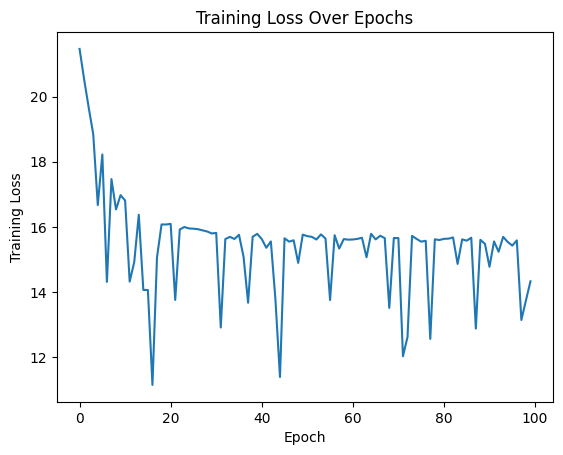

In [ ]:
plt.plot(history)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.title("Training Loss Over Epochs")